**Run in Colab with GPU, If Running in CPU the training time for models will be more than 30 mins. Read through the instructions for each cells for execting without any errors**

In [1]:
#ignore this if you are not using colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Urls and Videos Reffered for this**

1.   https://www.youtube.com/watch?v=mHPpCXqQd7Y
2. https://www.youtube.com/watch?v=4F-cwOkMdTE&t=970s
3. https://www.youtube.com/watch?v=uTFU7qThylE
4.   https://towardsdatascience.com/audio-classification-with-pre-trained-vgg-19-keras-bca55c2a0efe
5. https://medium.com/analytics-vidhya/deep-learning-audio-classification-fcbed546a2dd
6. https://www.youtube.com/playlist?list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0




##Install Packages and Import

In [ ]:
!pip install catboost
!pip install librosa
!pip install mutagen

In [1]:
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
from scipy.io import wavfile as wav
import pandas as pd
import seaborn as sns
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
import shutil
from mutagen.mp3 import MP3
from mutagen.wave import WAVE
from catboost import CatBoostClassifier
from sklearn import linear_model
from sklearn.linear_model import  LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, cross_validate

import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
import pickle as pkl

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


##Load dataset and explore

In [26]:

#Load train and test dataset, # Change these paths as per your dataset location
df_train=pd.read_csv('train.csv') 
df_test=pd.read_csv('test.csv')
print(df_train.shape, df_test.shape)

train_dir='/content/drive/MyDrive/Hackathon/Voice Emotion Detection/TrainAudioFiles'
test_dir='/content/drive/MyDrive/Hackathon/Voice Emotion Detection/TestAudioFiles'

(5815, 2) (2492, 1)


In [5]:
df_train.head(5)

,filename,emotion
0,18777.mp3,neutral
1,24041.mp3,neutral
2,1621.mp3,joy
3,28883.mp3,neutral
4,14918.mp3,neutral


neutral     2630
joy          967
surprise     640
anger        596
sadness      344
fear         327
disgust      311
Name: emotion, dtype: int64


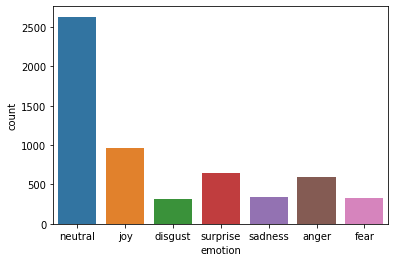

In [6]:
#Class distribution
sns.countplot(df_train.emotion)
print(df_train.emotion.value_counts())

More neutral classes and fear, disgust are less

neutral


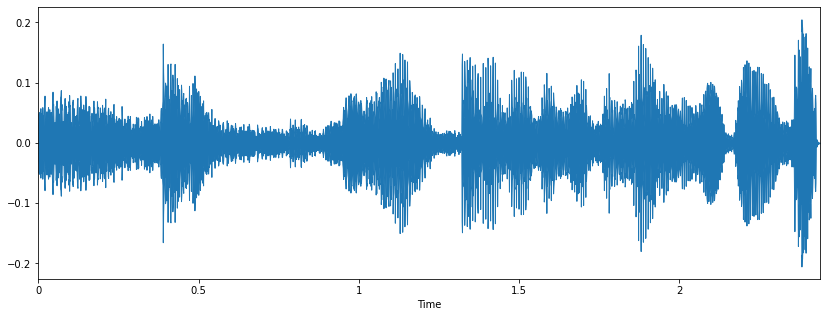

In [7]:
#Load one sample file and see
file_name=df_train['filename'][0]
filename='TrainAudioFiles/'+file_name  #change the folder path as per your data
#filename=train_dir+'/'+file_name  #change the folder path as per your data
emotion=df_train['emotion'][0]

#Plot a single file
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)
print(emotion)

In [8]:
ipd.Audio(filename)

In [ ]:
#checking the lebgth of single mp3, wav file
audio = MP3("TrainAudioFiles/1621.mp3")
print(audio.info.length)

audio = WAVE("TrainAudioFiles/50105.wav")
print(audio.info.length)

0.39183673469387753
2.5025


In [ ]:
#Training Data duration analysis
Lengths=[]
Error=[]
for index_num,row in tqdm(df_train.iterrows()):
  file_name = os.path.join('TrainAudioFiles/',str(row["filename"]))
  if('.mp3' in file_name):
    audio = MP3(file_name)
    Lengths.append(np.round(audio.info.length,2))
  else:
    try:
      audio = WAVE(file_name)
      Lengths.append(np.round(audio.info.length,2))
    except:
      Lengths.append(4.0) # for 38543.wav audio I was getting error , so manually added the length
      Error.append(file_name)

5815it [00:03, 1490.75it/s]


In [ ]:
#Testing Data duration analysis
Test_Lengths=[]
Test_Error=[]
for index_num,row in tqdm(df_test.iterrows()):
  file_name = os.path.join('TestAudioFiles/',str(row["filename"]))
  if('.mp3' in file_name):
    audio = MP3(file_name)
    Test_Lengths.append(np.round(audio.info.length,2))
  else:
    try:
      audio = WAVE(file_name)
      Test_Lengths.append(np.round(audio.info.length,2))
    except:
      Test_Lengths.append(100.00) #None of the test audios created any exception while loading
      Test_Error.append(file_name)
  
    

2492it [00:01, 1549.74it/s]


In [ ]:
df_test_new=df_test.copy()
df_train_new=df_train.copy()
df_test_new['Duration']=Test_Lengths
df_train_new['Duration']=Lengths

In [ ]:
df_train_new.describe()

,Duration
count,5815.000000
mean,3.124781
std,2.282762
min,0.130000
25%,1.720000
50%,2.510000
75%,3.740000
max,20.240000


Min length is .13 and max is 20.24 sec

In [ ]:
df_test_new.describe()

,Duration
count,2492.000000
mean,3.220778
std,2.626744
min,0.130000
25%,1.665000
50%,2.540000
75%,3.890000
max,41.090000


Min length is .13 and max is 41.09 sec

In [ ]:
#find files with less than .6 sec
df_train_new=df_train_new.loc[df_train_new.Duration<.6]
df_test_new=df_test_new.loc[df_test_new.Duration<.6]

neutral     89
joy         36
surprise    17
anger       14
sadness      7
fear         2
disgust      1
Name: emotion, dtype: int64


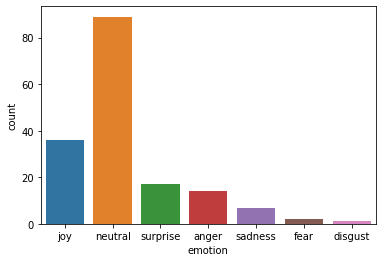

In [ ]:
#plot the data
sns.countplot(df_train_new['emotion'])
print(df_train_new['emotion'].value_counts())

In [ ]:
print(df_train_new.shape, df_test_new.shape)
#166 , 93 files have less than .6sec duration in train and test set respectively. 
#This duration might be very difficult to distinguish the emotion of a sound

(166, 3) (93, 2)


## Data preprocessing - Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [9]:
#Function for Feature extraction
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

**Next Two cells are to extract the MFCCs for train and test audio data. This will take some time (more than 1hr). Please skip next two cells and read it from the pickle file provided as part of the source file. If in case you are running these cells, please ignore the load from pickle cells**

In [ ]:
### Now we iterate through every Train audio file and extract features 
### using Mel-Frequency Cepstral Coefficients

extracted_features=[]
for index_num,row in tqdm(df_train.iterrows()):
    file_name = os.path.join('TrainAudioFiles/',str(row["filename"]))
    #print(file_name)
    final_class_labels=row["emotion"]
    #print(final_class_labels)
    #break
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

In [ ]:
### Now we iterate through every Test audio file and extract features 
### using Mel-Frequency Cepstral Coefficients

test_data=[]
for index_num,row in tqdm(df_test.iterrows()):
    file_name = os.path.join('TestAudioFiles/',str(row["filename"]))
    
    data=features_extractor(file_name)
    
    test_data.append([data,'dummy']) # along with feature appending dummy label for emotion for now
    

In [10]:
#Load from the aready processed and saved pickle files for faster execution.
extracted_features=pkl.load(open('extracted_features.sav', 'rb'))
test_data=pkl.load(open('test_data.sav', 'rb'))

In [11]:
# Function for downloading the submission file
def download_submission(model, isDeepLarning=False):
  test_features_df=pd.DataFrame(test_data,columns=['feature','class'])
  if(isDeepLarning):
    test_result=model.predict(np.array(test_features_df['feature'].tolist()))
    classes=np.argmax(test_result,axis=1)
    prediction_class = labelencoder.inverse_transform(classes) 
    df_test_submission=df_test.copy()
    df_test_submission['emotion']=prediction_class
  else:
    test_result=classifier.predict(np.array(test_features_df['feature'].tolist()))
    df_test_submission=df_test.copy()
    df_test_submission['emotion']=test_result

    df_test_submission.loc[df_test_submission['emotion'] == 0, 'emotion'] = 'neutral'
    df_test_submission.loc[df_test_submission['emotion'] == 1, 'emotion'] = 'joy'
    df_test_submission.loc[df_test_submission['emotion'] ==2 , 'emotion'] = 'disgust'
    df_test_submission.loc[df_test_submission['emotion'] == 3, 'emotion'] = 'surprise'
    df_test_submission.loc[df_test_submission['emotion'] == 4, 'emotion'] = 'sadness'
    df_test_submission.loc[df_test_submission['emotion'] == 5, 'emotion'] = 'fear'
    df_test_submission.loc[df_test_submission['emotion'] == 6, 'emotion'] = 'anger'                                   

  df_test_submission.to_csv('submission.csv',index=False)

  try:
    from google.colab import files
    files.download('submission.csv')
  except ImportError as e:
    print("Only for Colab")

##Data split for Model creation and Validation with different models

In [12]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-283.33044, 126.99498, -36.858562, 43.749313,...",neutral
1,"[-291.48148, 85.954155, -31.5776, 28.470999, -...",neutral
2,"[-362.78958, 123.9907, -15.951502, 73.428764, ...",joy
3,"[-236.65022, 117.452545, -47.395702, 15.700617...",neutral
4,"[-395.161, 87.821884, -8.653343, 25.291254, -2...",neutral


In [13]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())
X.shape, y.shape

((5816, 40), (5816,))

In [14]:
### Label Encoding

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [15]:

### Train Test Split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((4652, 40), (1164, 40), (4652, 7), (1164, 7))

#Checking with Multiple Models

## Custom Deep Learning Model

In [16]:
### No of classes
num_labels=y.shape[1]
num_labels

7


Optimal number of hidden layers and neurons are idendified after multiple iterations.

In [ ]:
#Custom Model 
model=Sequential()
###first layer
model.add(Dense(250,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

###second layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.2))

###second layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.2))


###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
#compile model
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
#Train the Model
num_epochs = 600
num_batch_size = 16

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), 
          callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/600
291/291 [==============================] - 1s 3ms/step - loss: 3.2715 - accuracy: 0.3601 - val_loss: 1.5070 - val_accuracy: 0.4699

Epoch 00001: val_loss improved from inf to 1.50705, saving model to saved_models/audio_classification.hdf5
Epoch 2/600
291/291 [==============================] - 1s 2ms/step - loss: 1.5233 - accuracy: 0.4721 - val_loss: 1.4092 - val_accuracy: 0.4837

Epoch 00002: val_loss improved from 1.50705 to 1.40922, saving model to saved_models/audio_classification.hdf5
Epoch 3/600
291/291 [==============================] - 1s 2ms/step - loss: 1.4501 - accuracy: 0.4976 - val_loss: 1.4153 - val_accuracy: 0.4734

Epoch 00003: val_loss did not improve from 1.40922
Epoch 4/600
291/291 [==============================] - 1s 2ms/step - loss: 1.4039 - accuracy: 0.5037 - val_loss: 1.4235 - val_accuracy: 0.4828

Epoch 00004: val_loss did not improve from 1.40922
Epoch 5/600
291/291 [==============================] - 1s 2ms/step - loss: 1.3851 - accuracy: 0.5056 - v

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=1)
print(test_accuracy[1])

37/37 [==============================] - 0s 2ms/step - loss: 2.0914 - accuracy: 0.5000
0.5


In [ ]:
#Predict
download_submission(model, True)
#score in Hacker Earth - 52.95

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Train the Model With Full data
num_epochs = 600
num_batch_size = 16

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X, y, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer],
          verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/600
364/364 [==============================] - 1s 3ms/step - loss: 1.1375 - accuracy: 0.6338 - val_loss: 1.3768 - val_accuracy: 0.5129

Epoch 00001: val_loss improved from inf to 1.37682, saving model to saved_models/audio_classification.hdf5
Epoch 2/600
364/364 [==============================] - 1s 2ms/step - loss: 1.0985 - accuracy: 0.6339 - val_loss: 1.3521 - val_accuracy: 0.5275

Epoch 00002: val_loss improved from 1.37682 to 1.35214, saving model to saved_models/audio_classification.hdf5
Epoch 3/600
364/364 [==============================] - 1s 2ms/step - loss: 1.0262 - accuracy: 0.6499 - val_loss: 1.3011 - val_accuracy: 0.5155

Epoch 00003: val_loss improved from 1.35214 to 1.30107, saving model to saved_models/audio_classification.hdf5
Epoch 4/600
364/364 [==============================] - 1s 2ms/step - loss: 1.0180 - accuracy: 0.6515 - val_loss: 1.2469 - val_accuracy: 0.5404

Epoch 00004: val_loss improved from 1.30107 to 1.24685, saving model to saved_models/audio_clas

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=1)
print(test_accuracy[1])

37/37 [==============================] - 0s 2ms/step - loss: 0.5767 - accuracy: 0.7981
0.7981099486351013


In [ ]:
#Predict
download_submission(model, True)
#score in HE 56.77

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Training with full data gives better score in Hacker Earth. So full data will be used for training going forward.**

##Train with multiple Machine Learning algorithms and cross validate the scores


In [17]:
#Preprocessing for ML Algorithms
extracted_features_df['class_code']=extracted_features_df['class']
extracted_features_df.loc[extracted_features_df['class_code'] == 'neutral', 'class_code'] = 0
extracted_features_df.loc[extracted_features_df['class_code'] == 'joy', 'class_code'] = 1
extracted_features_df.loc[extracted_features_df['class_code'] == 'disgust', 'class_code'] = 2
extracted_features_df.loc[extracted_features_df['class_code'] == 'surprise', 'class_code'] = 3
extracted_features_df.loc[extracted_features_df['class_code'] == 'sadness', 'class_code'] = 4
extracted_features_df.loc[extracted_features_df['class_code'] == 'fear', 'class_code'] = 5
extracted_features_df.loc[extracted_features_df['class_code'] == 'anger', 'class_code'] = 6
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class_code'].tolist())

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

Change the task type if you are not using GPU

In [ ]:

models = [
 CatBoostClassifier(task_type="GPU"),
 LogisticRegression(penalty='l2', C=0.01, class_weight="balanced", solver = 'lbfgs', max_iter=1000),
 KNeighborsClassifier(),
 DecisionTreeClassifier(),
 GradientBoostingClassifier(),
 ExtraTreesClassifier(),
 LGBMClassifier(),
 XGBClassifier(task_type="GPU",learning_rate =0.01, n_estimators=800, max_depth=8, min_child_weight=7, gamma=0.2, subsample=0.6, 
     colsample_bytree=0.8,  eval_metric='auc'),
 RandomForestClassifier(n_estimators=500, random_state=42, 
            min_samples_leaf = 30, criterion='gini', max_depth=7, max_features='log2'),
OneVsRestClassifier(XGBClassifier())
          
] 

names = ["CatBoost",
         "Logreg C=0.01", "KNN", "DT","GradientBoost","ExtraTrees","LGM",
         "XGB", "RanFor","OneVsRestClassifier"] 

scoring = {'acc': 'accuracy',
           'prec': 'precision_macro',
           'rec': 'recall_macro',
           #'auc': 'roc_auc'
           }

for model, name in zip(models, names):
    scores = cross_validate(model, X, y, scoring=scoring, cv=5, return_train_score=True)
    print(name)
    #print(scores.keys())
    #break
    print('Train Accuracy: %5.2f,  Test Accuracy: %5.2f' % (np.average(scores['train_acc']), np.average(scores['test_acc'])))
    print('Train Precision: %5.2f,  Test Precision: %5.2f'% (np.average(scores['train_prec']), np.average(scores['test_prec'])))
    print('Train Recall: %5.2f,  Test Recall: %5.2f'% (np.average(scores['train_rec']), np.average(scores['test_rec'])))
    

Learning rate set to 0.088814


0:	learn: 1.8400094	total: 13ms	remaining: 13s
1:	learn: 1.7608759	total: 19.6ms	remaining: 9.8s
2:	learn: 1.6971635	total: 25.8ms	remaining: 8.59s
3:	learn: 1.6462863	total: 31.8ms	remaining: 7.93s
4:	learn: 1.6046245	total: 37.7ms	remaining: 7.51s
5:	learn: 1.5677741	total: 43.6ms	remaining: 7.23s
6:	learn: 1.5356450	total: 49.7ms	remaining: 7.05s
7:	learn: 1.5075873	total: 55.7ms	remaining: 6.91s
8:	learn: 1.4850759	total: 61.7ms	remaining: 6.79s
9:	learn: 1.4649221	total: 68.3ms	remaining: 6.76s
10:	learn: 1.4448517	total: 75.1ms	remaining: 6.75s
11:	learn: 1.4276318	total: 82.2ms	remaining: 6.76s
12:	learn: 1.4121143	total: 89ms	remaining: 6.76s
13:	learn: 1.3986833	total: 95.7ms	remaining: 6.74s
14:	learn: 1.3862388	total: 102ms	remaining: 6.71s
15:	learn: 1.3743361	total: 109ms	remaining: 6.7s
16:	learn: 1.3648719	total: 115ms	remaining: 6.64s
17:	learn: 1.3553904	total: 122ms	remaining: 6.63s
18:	learn: 1.3470644	total: 128ms	remaining: 6.62s
19:	learn: 1.3387569	total: 135ms	r

0:	learn: 1.8369212	total: 10.2ms	remaining: 10.2s
1:	learn: 1.7577976	total: 16.6ms	remaining: 8.3s
2:	learn: 1.6959408	total: 22.6ms	remaining: 7.5s
3:	learn: 1.6433425	total: 28.3ms	remaining: 7.05s
4:	learn: 1.6015617	total: 34ms	remaining: 6.77s
5:	learn: 1.5656993	total: 39.8ms	remaining: 6.6s
6:	learn: 1.5333318	total: 45.6ms	remaining: 6.47s
7:	learn: 1.5052582	total: 51.4ms	remaining: 6.38s
8:	learn: 1.4829586	total: 57.1ms	remaining: 6.29s
9:	learn: 1.4613536	total: 63.3ms	remaining: 6.27s
10:	learn: 1.4425089	total: 69.1ms	remaining: 6.21s
11:	learn: 1.4258113	total: 74.8ms	remaining: 6.16s
12:	learn: 1.4106686	total: 81.6ms	remaining: 6.2s
13:	learn: 1.3967404	total: 87.4ms	remaining: 6.16s
14:	learn: 1.3836995	total: 93.2ms	remaining: 6.12s
15:	learn: 1.3721815	total: 98.9ms	remaining: 6.08s
16:	learn: 1.3615744	total: 105ms	remaining: 6.05s
17:	learn: 1.3523031	total: 111ms	remaining: 6.03s
18:	learn: 1.3439953	total: 117ms	remaining: 6.03s
19:	learn: 1.3357314	total: 123

0:	learn: 1.8432499	total: 10.2ms	remaining: 10.2s
1:	learn: 1.7635231	total: 17.2ms	remaining: 8.6s
2:	learn: 1.6994919	total: 24.3ms	remaining: 8.07s
3:	learn: 1.6492770	total: 31.5ms	remaining: 7.84s
4:	learn: 1.6082384	total: 38.7ms	remaining: 7.69s
5:	learn: 1.5725449	total: 44.8ms	remaining: 7.43s
6:	learn: 1.5393404	total: 50.6ms	remaining: 7.18s
7:	learn: 1.5118934	total: 56.2ms	remaining: 6.97s
8:	learn: 1.4885155	total: 61.9ms	remaining: 6.81s
9:	learn: 1.4664225	total: 67.4ms	remaining: 6.67s
10:	learn: 1.4484215	total: 73.1ms	remaining: 6.57s
11:	learn: 1.4309154	total: 78.6ms	remaining: 6.47s
12:	learn: 1.4145010	total: 84.1ms	remaining: 6.39s
13:	learn: 1.4007214	total: 89.6ms	remaining: 6.31s
14:	learn: 1.3882408	total: 95ms	remaining: 6.24s
15:	learn: 1.3759499	total: 101ms	remaining: 6.19s
16:	learn: 1.3654433	total: 106ms	remaining: 6.14s
17:	learn: 1.3562295	total: 113ms	remaining: 6.14s
18:	learn: 1.3472501	total: 120ms	remaining: 6.17s
19:	learn: 1.3394581	total: 1

0:	learn: 1.8405347	total: 6.95ms	remaining: 6.95s
1:	learn: 1.7626880	total: 12.7ms	remaining: 6.32s
2:	learn: 1.6973303	total: 19.6ms	remaining: 6.5s
3:	learn: 1.6442052	total: 26.3ms	remaining: 6.56s
4:	learn: 1.6020952	total: 33.9ms	remaining: 6.75s
5:	learn: 1.5656070	total: 40.7ms	remaining: 6.75s
6:	learn: 1.5344461	total: 46.2ms	remaining: 6.55s
7:	learn: 1.5066525	total: 52.5ms	remaining: 6.51s
8:	learn: 1.4838280	total: 58ms	remaining: 6.38s
9:	learn: 1.4624966	total: 64.2ms	remaining: 6.35s
10:	learn: 1.4434901	total: 71.5ms	remaining: 6.43s
11:	learn: 1.4267372	total: 78.2ms	remaining: 6.44s
12:	learn: 1.4111932	total: 83.7ms	remaining: 6.36s
13:	learn: 1.3978057	total: 90.5ms	remaining: 6.37s
14:	learn: 1.3851352	total: 97.3ms	remaining: 6.39s
15:	learn: 1.3723095	total: 103ms	remaining: 6.36s
16:	learn: 1.3613018	total: 109ms	remaining: 6.31s
17:	learn: 1.3518899	total: 116ms	remaining: 6.32s
18:	learn: 1.3448564	total: 122ms	remaining: 6.32s
19:	learn: 1.3365793	total: 1

0:	learn: 1.8364805	total: 13.8ms	remaining: 13.8s
1:	learn: 1.7585095	total: 20.6ms	remaining: 10.3s
2:	learn: 1.6956325	total: 27.3ms	remaining: 9.09s
3:	learn: 1.6432088	total: 34.2ms	remaining: 8.51s
4:	learn: 1.6003144	total: 41ms	remaining: 8.17s
5:	learn: 1.5639046	total: 46.6ms	remaining: 7.72s
6:	learn: 1.5320683	total: 52.3ms	remaining: 7.41s
7:	learn: 1.5040718	total: 57.8ms	remaining: 7.17s
8:	learn: 1.4819979	total: 63.4ms	remaining: 6.98s
9:	learn: 1.4605911	total: 68.8ms	remaining: 6.81s
10:	learn: 1.4410023	total: 74.2ms	remaining: 6.67s
11:	learn: 1.4235560	total: 79.8ms	remaining: 6.57s
12:	learn: 1.4071273	total: 85.3ms	remaining: 6.47s
13:	learn: 1.3938263	total: 92.6ms	remaining: 6.52s
14:	learn: 1.3813163	total: 99.5ms	remaining: 6.53s
15:	learn: 1.3695861	total: 106ms	remaining: 6.53s
16:	learn: 1.3594464	total: 113ms	remaining: 6.54s
17:	learn: 1.3497325	total: 120ms	remaining: 6.55s
18:	learn: 1.3405901	total: 127ms	remaining: 6.55s
19:	learn: 1.3325388	total: 

**Result of above cell execution**


```
CatBoost
Train Accuracy:  1.00,  Test Accuracy:  0.56
Train Precision:  1.00,  Test Precision:  0.58
Train Recall:  1.00,  Test Recall:  0.39
Logreg C=0.01
Train Accuracy:  0.33,  Test Accuracy:  0.30
Train Precision:  0.38,  Test Precision:  0.34
Train Recall:  0.40,  Test Recall:  0.35
KNN
Train Accuracy:  0.61,  Test Accuracy:  0.47
Train Precision:  0.60,  Test Precision:  0.36
Train Recall:  0.46,  Test Recall:  0.32
DT
Train Accuracy:  1.00,  Test Accuracy:  0.43
Train Precision:  1.00,  Test Precision:  0.36
Train Recall:  1.00,  Test Recall:  0.36
GradientBoost
Train Accuracy:  0.71,  Test Accuracy:  0.52
Train Precision:  0.92,  Test Precision:  0.47
Train Recall:  0.62,  Test Recall:  0.33
ExtraTrees
Train Accuracy:  1.00,  Test Accuracy:  0.58
Train Precision:  1.00,  Test Precision:  0.77
Train Recall:  1.00,  Test Recall:  0.39
LGM
Train Accuracy:  0.98,  Test Accuracy:  0.56
Train Precision:  0.99,  Test Precision:  0.61
Train Recall:  0.98,  Test Recall:  0.38
XGB
Train Accuracy:  0.91,  Test Accuracy:  0.56
Train Precision:  0.97,  Test Precision:  0.63
Train Recall:  0.85,  Test Recall:  0.37
RanFor
Train Accuracy:  0.53,  Test Accuracy:  0.51
Train Precision:  0.41,  Test Precision:  0.25
Train Recall:  0.33,  Test Recall:  0.29
OneVsRestClassifier
Train Accuracy:  0.63,  Test Accuracy:  0.52
Train Precision:  0.87,  Test Precision:  0.50
Train Recall:  0.48,  Test Recall:  0.33
```






**Validating With Multiple Algorithms from above list, Catboost gave better score in Hacker Earth**

##Catboost

**Catboost gave better result in Hacker earth.
Now doing Hyper parameter turning and validating further**

In [ ]:
classifier=CatBoostClassifier(task_type="GPU",devices='0:1',                           
                            )


classifier.fit(X,y)

y_pred=classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Learning rate set to 0.092954
0:	learn: 1.8322248	total: 16.5ms	remaining: 16.4s
1:	learn: 1.7529381	total: 31.1ms	remaining: 15.5s
2:	learn: 1.6886824	total: 45.6ms	remaining: 15.2s
3:	learn: 1.6363802	total: 59.8ms	remaining: 14.9s
4:	learn: 1.5935975	total: 74.1ms	remaining: 14.7s
5:	learn: 1.5560022	total: 88.4ms	remaining: 14.6s
6:	learn: 1.5242791	total: 102ms	remaining: 14.5s
7:	learn: 1.4973188	total: 117ms	remaining: 14.5s
8:	learn: 1.4735055	total: 132ms	remaining: 14.5s
9:	learn: 1.4530948	total: 147ms	remaining: 14.5s
10:	learn: 1.4344665	total: 161ms	remaining: 14.5s
11:	learn: 1.4185009	total: 175ms	remaining: 14.4s
12:	learn: 1.4037568	total: 189ms	remaining: 14.4s
13:	learn: 1.3908223	total: 214ms	remaining: 15s
14:	learn: 1.3795079	total: 231ms	remaining: 15.2s
15:	learn: 1.3687047	total: 246ms	remaining: 15.1s
16:	learn: 1.3587624	total: 260ms	remaining: 15s
17:	learn: 1.3498601	total: 275ms	remaining: 15s
18:	learn: 1.3416952	total: 290ms	remaining: 15s
19:	learn: 1.

In [ ]:
#Predict
download_submission(classifier)
#With Base Model score in HE - 58.67

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Hyper parameter turning with ramdomized  Search.
This Will Run for around 60 Minutes in GPU, Skip below cell if you are validating and proceed with next cell.**

In [ ]:
#Hyper parameter turning with ramdomized  Search
#This Will Run for around 60 Minutes in GPU, Skip this cell if you are validating and proceed with next cell.

grid = {'max_depth': [6,8,10],'n_estimators':[500, 600, 700,800,900, 1000],'l2_leaf_reg': [1,2, 3],
        'learning_rate': [0.01,0.02,0.03, 0.04], 
        }
model=CatBoostClassifier(task_type="GPU",
                           devices='0:1')
randomized_search_result = model.randomized_search(grid,
                                                   X=X,
                                                   y=y,
                                                   plot=True,cv=5)
randomized_search_result.values()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
519:	learn: 0.6254184	test: 1.2361058	best: 1.2361058 (519)	total: 6.53s	remaining: 1s
520:	learn: 0.6247046	test: 1.2359506	best: 1.2359506 (520)	total: 6.55s	remaining: 993ms
521:	learn: 0.6241258	test: 1.2358444	best: 1.2358444 (521)	total: 6.56s	remaining: 980ms
522:	learn: 0.6237712	test: 1.2358525	best: 1.2358444 (521)	total: 6.57s	remaining: 968ms
523:	learn: 0.6228846	test: 1.2357884	best: 1.2357884 (523)	total: 6.58s	remaining: 955ms
524:	learn: 0.6217858	test: 1.2356932	best: 1.2356932 (524)	total: 6.6s	remaining: 943ms
525:	learn: 0.6204067	test: 1.2354896	best: 1.2354896 (525)	total: 6.61s	remaining: 930ms
526:	learn: 0.6193145	test: 1.2355294	best: 1.2354896 (525)	total: 6.63s	remaining: 918ms
527:	learn: 0.6182639	test: 1.2353797	best: 1.2353797 (527)	total: 6.64s	remaining: 905ms
528:	learn: 0.6172526	test: 1.2355686	best: 1.2353797 (527)	total: 6.65s	remaining: 893ms
529:	learn: 0.6162573	test: 1.2354860	best: 1.2353797

dict_values([{'depth': 10, 'l2_leaf_reg': 3, 'iterations': 900, 'learning_rate': 0.03}, defaultdict(<class 'list'>, {'iterations': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195

In [18]:
#Using Hyparameter turned model
classifier=CatBoostClassifier(task_type="GPU",devices='0:1', 
                              depth= 10, l2_leaf_reg= 3, iterations= 900, learning_rate= 0.03 
                              
                              )


classifier.fit(X,y)


y_pred=classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0:	learn: 1.9140439	total: 78.6ms	remaining: 1m 10s
1:	learn: 1.8876995	total: 160ms	remaining: 1m 11s
2:	learn: 1.8605220	total: 236ms	remaining: 1m 10s
3:	learn: 1.8342571	total: 316ms	remaining: 1m 10s
4:	learn: 1.8091101	total: 393ms	remaining: 1m 10s
5:	learn: 1.7876349	total: 475ms	remaining: 1m 10s
6:	learn: 1.7665582	total: 547ms	remaining: 1m 9s
7:	learn: 1.7477787	total: 615ms	remaining: 1m 8s
8:	learn: 1.7280307	total: 681ms	remaining: 1m 7s
9:	learn: 1.7094105	total: 743ms	remaining: 1m 6s
10:	learn: 1.6926956	total: 812ms	remaining: 1m 5s
11:	learn: 1.6776508	total: 882ms	remaining: 1m 5s
12:	learn: 1.6618844	total: 940ms	remaining: 1m 4s
13:	learn: 1.6457471	total: 995ms	remaining: 1m 2s
14:	learn: 1.6316172	total: 1.07s	remaining: 1m 3s
15:	learn: 1.6173170	total: 1.13s	remaining: 1m 2s
16:	learn: 1.6039064	total: 1.19s	remaining: 1m 1s
17:	learn: 1.5915049	total: 1.25s	remaining: 1m 1s
18:	learn: 1.5779474	total: 1.31s	remaining: 1m
19:	learn: 1.5658783	total: 1.37s	rem

In [ ]:
download_submission(classifier)
##With Tuned Model score in HE - 58.77633

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Above is the best score I have received**

## Another Approach By Converting the audio to Image and using CNN,  Transfer Learning

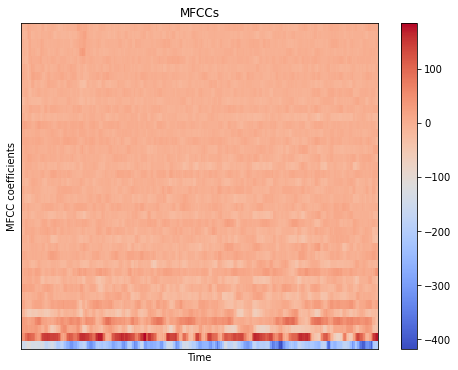

In [ ]:
#Displaying Mel Frequency Cepstral Coefficients (MFCC) for an audio file

file=r'TrainAudioFiles/0.mp3'
signal, sample_rate = librosa.load(file, sr=22050)
# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples
# MFCCs
# extract 40 MFCCs
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=40)
# display MFCCs
plt.figure(figsize=(8,6))
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")
# show the plot
plt.show()

In [ ]:
#Train Audios to Image
#Time taking process depends on the machine
if not os.path.exists("Train_Images"):
    os.makedirs("Train_Images")
    
for index_num,row in tqdm(df_train.iterrows()):
    plt.figure(figsize=(8,6))
    file_name = os.path.join('TrainAudioFiles/',str(row["filename"]))
    signal, sample_rate = librosa.load(file_name, sr=22050)
    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=40)
    librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)    
    plt.savefig("Train_Images/" + row["filename"].split('.')[0] + '.png')
    plt.close('all')

5816it [1:52:00,  1.16s/it]


In [ ]:
#Test Audios to Image
#Time taking process depends on the machine
if not os.path.exists("Test_Images"):
    os.makedirs("Test_Images")
    
for index_num,row in tqdm(df_test.iterrows()):
    plt.figure(figsize=(8,6))
    file_name = os.path.join('TestAudioFiles/',str(row["filename"]))
    signal, sample_rate = librosa.load(file_name, sr=22050)
    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=40)
    librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
    plt.savefig("Test_Images/" + row["filename"].split('.')[0] + '.png')
    plt.close('all')

2492it [1:22:51,  1.99s/it]



In [ ]:
#Change the path as per your data
train_dir_img='Train_Images'
test_dir_img='Test_Images'

In [ ]:
print(df_train.shape, df_test.shape)
labels=df_train.emotion.unique()

(5815, 2) (2492, 1)


In [ ]:
img_size = 224

In [ ]:
train_imageNames=[]
def get_data(df):
  data = []
  for index_num,row in tqdm(df.iterrows()):    
    file_name = os.path.join(train_dir_img+'/',str(row["filename"].split('.')[0])+'.png')
    img_arr = cv2.imread(file_name)[...,::-1] #convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
    class_num=np.where( labels==row['emotion'])[0][0]
    data.append([resized_arr, class_num])
    train_imageNames.append(str(row["filename"].split('.')[0])+'.png')

    #print(resized_arr)
    #print(class_num)
    #print(train_imageNames)
    #break;
  return np.array(data)

In [ ]:
#Now we can easily fetch our train and validation data.
train = get_data(df_train)

5815it [00:30, 192.60it/s]


In [ ]:
len(train_imageNames)

5815

Text(0.5, 1.0, 'neutral')

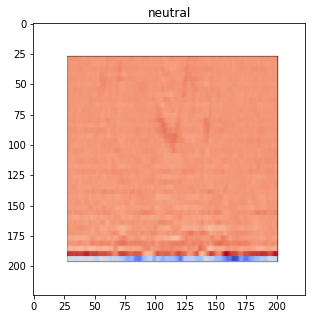

In [ ]:
#visualize a random image
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

In [ ]:
#Data Preprocessing and Data Augmentation
X=[]
y=[]
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  X.append(feature)
  y.append(label)


x_train,x_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=0)


# Normalize the data
XX=np.array(X) / 255 ##added for train with full dataset
#x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

XX.reshape(-1, img_size, img_size, 1) ##added for train with full dataset
#x_train.reshape(-1, img_size, img_size, 1)
#y_train = np.array(y_train)
yy=np.array(y) ##added for train with full dataset

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(x_train) #removed transforms as it is audio image data

In [ ]:
#Transfr Learning- Import the model -MobileNet
base_model = tf.keras.applications.VGG19(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")

In [ ]:
#freeze our base before we compile
base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(len(labels), activation="softmax")                                     
                                ])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
num_epochs=30
history = model.fit(XX,yy,epochs = num_epochs , validation_data = (x_val, y_val), batch_size=16)

Epoch 1/30
364/364 [==============================] - 21s 57ms/step - loss: 1.6548 - accuracy: 0.4382 - val_loss: 1.6881 - val_accuracy: 0.4248
Epoch 2/30
364/364 [==============================] - 17s 48ms/step - loss: 1.6223 - accuracy: 0.4523 - val_loss: 1.6600 - val_accuracy: 0.4248
Epoch 3/30
364/364 [==============================] - 17s 48ms/step - loss: 1.6110 - accuracy: 0.4523 - val_loss: 1.6475 - val_accuracy: 0.4248
Epoch 4/30
364/364 [==============================] - 17s 48ms/step - loss: 1.5980 - accuracy: 0.4521 - val_loss: 1.6513 - val_accuracy: 0.4248
Epoch 5/30
364/364 [==============================] - 17s 48ms/step - loss: 1.5859 - accuracy: 0.4523 - val_loss: 1.6224 - val_accuracy: 0.4248
Epoch 6/30
364/364 [==============================] - 17s 48ms/step - loss: 1.5761 - accuracy: 0.4523 - val_loss: 1.6155 - val_accuracy: 0.4248
Epoch 7/30
364/364 [==============================] - 17s 48ms/step - loss: 1.5674 - accuracy: 0.4523 - val_loss: 1.6075 - val_accuracy:

In [ ]:
model.save('model1/')

INFO:tensorflow:Assets written to: model1/assets


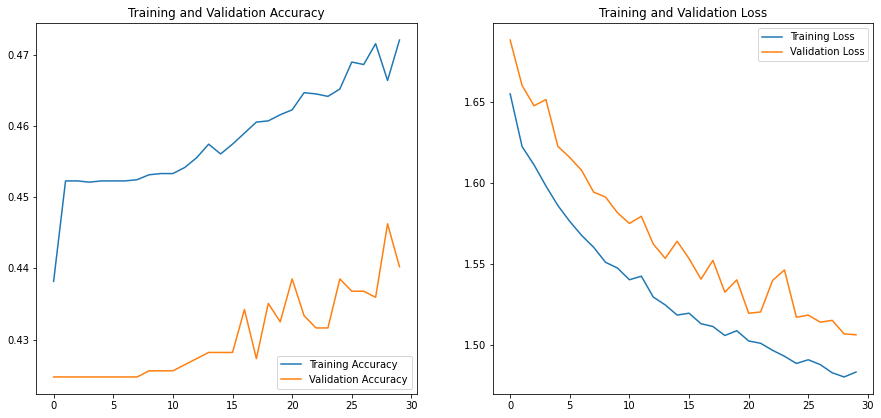

In [ ]:
#Evaluating the result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#print the classification report

predictions = prediction =np.argmax(model.predict(x_val), axis=-1)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_val, predictions, target_names = labels))

              precision    recall  f1-score   support

     neutral       0.44      1.00      0.61       494
         joy       0.00      0.00      0.00       182
     disgust       0.00      0.00      0.00        77
    surprise       0.00      0.00      0.00       139
     sadness       0.00      0.00      0.00        69
       anger       0.00      0.00      0.00       119
        fear       0.69      0.22      0.33        83

    accuracy                           0.44      1163
   macro avg       0.16      0.17      0.13      1163
weighted avg       0.23      0.44      0.28      1163



In [ ]:
def find_label(i):
  return (labels[i])

In [ ]:
#Predict for test set
test_imageNames=[]
data = []
for index_num,row in tqdm(df_test.iterrows()):    
  file_name = os.path.join(test_dir_img+'/',str(row["filename"].split('.')[0])+'.png')
  img_arr = cv2.imread(file_name)[...,::-1] #convert BGR to RGB format
  resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
  data.append([resized_arr])
  test_imageNames.append(str(row["filename"].split('.')[0])+'.png')


x_test = []
predictions=[]
for feature in data:
  x_test.append(feature)
# Normalize the data
x_test = np.array(x_test) / 255
x_test.reshape(-1, img_size, img_size, 1)

for row in tqdm(x_test):
  prediction =np.argmax(model.predict(row), axis=-1) 
  prediction = prediction.reshape(1,-1)[0]
  predictions.append(prediction[0])

2492it [00:13, 188.28it/s]
100%|██████████| 2492/2492 [01:58<00:00, 21.09it/s]


In [ ]:
result=[ find_label(x) for x in predictions ]

In [ ]:
df_test_submission=df_test.copy()
df_test_submission['emotion']=result
df_test_submission.to_csv('submission.csv',index=False)
try:
    from google.colab import files
    files.download('submission.csv')
except ImportError as e:
    print("Only for Colab")

#Hacker Earth Score - 45.7

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Hyparameter tuned Catboost model gave better result (58.77633) compared to other mathods.**

## Demo using Gradio

In [ ]:
#install gradio
!pip install gradio

In [2]:
#Import Libraries
import gradio as gr
import numpy as np
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from math import log2, pow

In [35]:
#Saving the catboost classifier if you just want to test the inference part alone you can ignore this cell
pkl.dump(classifier, open('model.pkl', 'wb'))

In [3]:
#Load the saved model.
loaded_model = pkl.load(open('model.pkl', 'rb'))

In [9]:
class_names=['neutral','joy','disgust','surprise','sadness','fear','anger']
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

#Function to predict for single sound file for demo 
def predict_audio(aud):
  #print('audio',aud.name)
  audio, sample_rate = librosa.load(aud.name, res_type='kaiser_fast') 
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
  #data=features_extractor(aud.name)
  #print('data',mfccs_scaled_features)
  
  prediction=loaded_model.predict_proba(mfccs_scaled_features)
  #print('prediction_prob',prediction)
  #print('predct',loaded_model.predict(mfccs_scaled_features))
  return {class_names[i]: float(prediction[i]) for i in range(7)}
  

In [11]:
#Creating Gradio interface for demo
audio=gr.inputs.Audio( source="upload", type="file", label=None)
iface = gr.Interface(
    predict_audio, 
    audio, 
    gr.outputs.Label(num_top_classes=7),
    
    interpretation="default")
iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://57254.gradio.app
Interface loading below...


KeyboardInterrupt: ignored